# Классификация на тестовых данных с помощью нейронной сети с одним скрытым слоем

В рамках данной лабораторной работы необходимо будет создать модель нейронной сети с одним скрытым слоем.

**В рамках данной лабораторной работы будут приобретены следующие навыки (знания):**
- Реализация нейронной сети с одним скрытым слоем для задачи классификации на 2 класса;
- Использование блоков с нелинейной функцией активации - tanh;
- Вычисление функции потерь кросс-энтропии (cross entropy loss);
- Реализация вычислений прямого и обратного распространения для нейронной сети.

`Данный материал опирается и использует материалы курса Deep Learning от организации deeplearning.ai`
 
 Ссылка на основной курс (для желающих получить дополнительный сертификаты): https://www.coursera.org/specializations/deep-learning

## 1 - Пакеты/Библиотеки

Первоначально необходимо запустить ячейку ниже, чтобы импортировать все пакеты, которые вам понадобятся во время лабораторной работы.
- [numpy](www.numpy.org) является основным пакетом для научных вычислений в Python.
- [sklearn](http://scikit-learn.org/stable/) предоставляет простые и эффективные инструменты для построения моделей и анализа данных.
- [matplotlib](http://matplotlib.org) это пакет для отрисовки графиков в Python.
- `planar_utils` предоставляет различные полезные функции, используемые в данной лабораторной работе.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # для того чтобы результаты были похожи на ответы необходимо сделать так, чтобы случайности были предсказуемы


## 2 - Датасет

Во-первых, давайте загрузим набор данных, с которым будем работать.
Следующий код загрузит набор данных из 2-х классов в переменные `X` and `Y`.

In [2]:
X, Y = load_planar_dataset()

Визуализируем датасет с использованием matplotlib.
Данные выглядят как "цветок" с красными (`y=0`) и синими (`y=1`) точками. Ваша цель построить модель, обучив её на этом датасете.

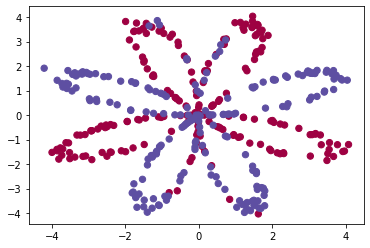

In [3]:
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

На входе:
    - numpy-array (матрица) X, который содержит признаки (x1, x2)
    - numpy-array (вектор) Y, который содержит метки (red:0, blue:1).

Давайте сначала лучше поймем наши данные.

**Упражнение** Как много примеров в обучающей выборке? Какой размер (`shape`) у переменных `X` и `Y`?

In [4]:
### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 3 строки кода)
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # размер обучающего датасета
### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###

print ('Размер X: ' + str(shape_X))
print ('Размер Y: ' + str(shape_Y))
print ('В выборке m = %d обучающих примеров!' % (m))

Размер X: (2, 400)
Размер Y: (1, 400)
В выборке m = 400 обучающих примеров!


**Ожидаемый результат**:
       
<table style="width:40%">
  <tr>
    <td>**shape of X**</td>
    <td> (2, 400) </td> 
  </tr>
  
  <tr>
    <td>**shape of Y**</td>
    <td>(1, 400) </td> 
  </tr>
  <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
</table>

## 3 - Логистическая регрессия

Прежде чем построить полную нейронную сеть, давайте сначала посмотрим, как работает логистическая регрессия в этой задаче.
Для этого можно использовать встроенные функции sklearn.
Выполните приведенный ниже код для создания классификатора на основе логистической регрессии.

In [5]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV()

Теперь вы можете построить границу принятия решения для этих моделей. Выполните приведенный ниже код.

Accuracy для логистической регрессии: 47 % (процент правильно размечанных алгоритмом точек данных)


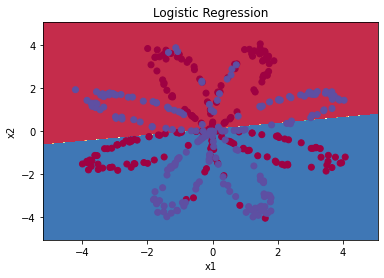

In [6]:
# Построение границы принятия решения для логистической регрессии
plot_decision_boundary(lambda x: clf.predict(x), X, Y[0])
plt.title("Logistic Regression")

# Вывод точности (accuracy) предсказания
LR_predictions = clf.predict(X.T)
print ('Accuracy для логистической регрессии: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(процент правильно размечанных алгоритмом точек данных)")

**Ожидаемый результат**:

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Интерпретация**: Набор данных не является линейно разделяемым, поэтому логистическая регрессия работает не достаточно хорошо.

## 4 - Модель нейронной сети

Логистическая регрессия плохо работала на "цветочном" наборе данных. Далее вы будете обучать нейронную сеть с одним скрытым слоем.

**Вот наша модель**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Математическое объяснение алгоритма**:

Для одного примера $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Учитывая прогнозы на всех примерах, вы также можете вычислить стоимость $J$ следующим образом: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Напоминание** Общая методология построения нейронной сети заключается в следующем:
    1. Определение структуры нейронной сети (`# количество нейронов на входе`,  `# количество нейронов в скрытом слое`, и т.п.).
    2. Инициализация параметров модели
    3. Цикл:
        - Прямой проход по нейронной сети
        - Вычисление потерь
        - Обратное распространение для получения градиентов 
        - Обновление параметров (градиентный спуск)

Вы часто создаете вспомогательные функции для вычисления шагов 1-3, а затем объединяете их в одну функцию, которую называется в нашем курсе `nn_model()`. Как только вы построили `nn_model()`, подобрав параметры, вы можете делать прогнозы по новым данным.

### 4.1 - Определение структуры нейронной сети

**Упражнение** Определить три параметра:
    - n_x: размер входного слоя
    - n_h: размер скрытого слоя (по дефолту установим в 4) 
    - n_y: размер выходного слоя

**Подсказка**: Используйте размеры X и Y для получения n_x и n_y.
Также, размер скрытого слоя должен быть равен 4 (вы можете менять данное значение).

In [7]:
# ОЦЕНИВАЕМОЕ: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- размер входного датасета (input size, number of examples)
    Y -- размер матрицы с метками (output size, number of examples)
    
    Returns:
    n_x -- размер входного слоя
    n_h -- размер скрытого слоя
    n_y -- размер выходного слоя
    """
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 3 строки кода)
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    return (n_x, n_h, n_y)

In [8]:
(n_x, n_h, n_y) = layer_sizes(X, Y)
print("n_x = " + str(n_x))
print("n_h = " + str(n_h))
print("n_y = " + str(n_y))

n_x = 2
n_h = 4
n_y = 1


**Ожидаемый результат**

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 2 </td> 
  </tr>
  <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  <tr>
    <td>**n_y**</td>
    <td> 1 </td> 
  </tr>
  
</table>

### 4.2 - Инициализация параметров модели ####

**Упражнение** Реализовать функцию `initialize_parameters()`.

**Инструкции**:
- Убедитесь в правильности размеров ваших параметров. При необходимости обратитесь к рисунку нейронной сети выше.
- Необходимо инициализировать матрицы весов случайными значениями.  Используйте: `np.random.randn(a,b) * 0.01` для инициализации матрицы со случайными значениями размером (a,b).
- Необходимо инициализировать векторы смещения как нули. Используйте: `np.zeros((a,b))` для инициализации матрицы с нулевыми значениями размером (a,b).

In [9]:
# ОЦЕНИВАЕМОЕ: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- размер входного слоя
    n_h -- размер скрытого слоя
    n_y -- размер выходного слоя
    
    Returns:
    params -- python словарь, содержащий следующие значения:
                    W1 -- матрица весов скрытого слоя размером (n_h, n_x)
                    b1 -- вектор смещений скрытого слоя размером (n_h, 1)
                    W2 -- матрица весов выходного слоя размером (n_y, n_h)
                    b2 -- вектор смещений выходного слоя размером (n_y, 1)
    """
    
    np.random.seed(2)
    
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 4 строки кода)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [10]:
parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Ожидаемый результат**: 

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - Цикл

**Упражнение** Реализуйте `forward_propagation()`.

**Инструкция**:
- Посмотрите выше на математическое представление классификатора.
- Вы можете использовать функцию `sigmoid()`. Она встроена в ноутбук.
- Вы можете использовать гиперболический тангенс `np.tanh()`. Это часть numpy библиотеки.
- Вы должны выполнить следующие шаги:
    1. Извлеките каждый параметр из словаря "parameters" (который является выводом `initialize_parameters()`) с использованием `parameters[".."]`.
    2. Реализуйте прямое распространение. Вычислите $Z^{[1]}, A^{[1]}, Z^{[2]}$ и $A^{[2]}$ (вектор всех ваших прогнозов на всех примерах в обучающем наборе).
- Значения, необходимые для обратного распространения, сохранить в "`cache`". `cache` будет передан в качестве входных данных для функции обратного распространения.

In [11]:
# ОЦЕНИВАЕМОЕ: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- размер матрицы признаков (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- результат вычисления sigmoid с выходного слоя
    cache -- словарь с параметрами "Z1", "A1", "Z2" и "A2"
    """
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 4 строки кода)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    # Реализуйте прямое распространение вычислив значение A2
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 4 строки кода)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [12]:
A2, cache = forward_propagation(X, parameters)

# Примечание: используется среднее значение здесь только для того, чтобы убедиться, что ваш вывод совпадает с ответом. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.0003302739109308174 0.00032973695550608985 -4.3569257945136905e-05 0.49998910768597105


Теперь, когда вы вычислили $A^{[2]}$, который содержит $a^{[2](i)}$ для каждого примера, вы можете вычислить функцию затрат следующим образом:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{7}$$

**Упражнение**: Реализуйте `compute_cost()` вычислив функцию потерь $J$.

**Инструкция**:
- Существует много способов реализовать кросс-энтропийную функцию потерь. Ниже приведён пример реализации
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs) # цикл нельзя использовать!
```


In [13]:
# ОЦЕНИВАЕМОЕ: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Вычисляет функцию потерь перекрестной энтропии, приведенную в уравнении (7)
    
    Arguments:
    A2 -- выход из выходного слоя нейронной сети (1, number of examples)
    Y -- "true" вектор меток (1, number of examples)
    parameters -- python словарь с параметрами W1, b1, W2 и b2
    
    Returns:
    cost -- cross-entropy результат вычисления функции потерь (7)
    """
    
    m = Y.shape[1] # number of example

    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)
    cost = -np.sum(logprobs)/m
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    cost = np.squeeze(cost) 
    assert(isinstance(cost, float))
    
    return cost

In [14]:
print("cost = " + str(compute_cost(A2, Y, parameters)))

cost = 0.6930480201239823


**Ожидаемый результат**: 

<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.6930480201239823 </td> 
  </tr>
  
</table>

Используя кэш, вычисленный во время прямого распространения, теперь можно реализовать обратное распространение.

**Упражнение** Реализуйте функцию `backward_propagation()`.

**Инструкция**:
Обратное распространение обычно является одной из самых трудных частей глубокого обучения. Вам в помощь ниже представлен краткий обзор используемых математических формул.

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    


- Подсказка:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`. !-->

In [15]:
# ОЦЕНИВАЕМОЕ: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Реализация обратного распространения ошибки
    
    Arguments:
    parameters -- python словарь с параметрами 
    cache -- словарь, содержащий "Z1", "A1", "Z2" и "A2".
    X -- матрица признаков (2, number of examples)
    Y -- вектор меток (1, number of examples)
    
    Returns:
    grads -- python словарь, содержащий градиенты относительно различных параметров
    """
    m = X.shape[1]
    
    # Получение W1 и W2 из словаря "parameters".
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    W1 = parameters ["W1"]
    W2 = parameters ["W2"]
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
        
    # Получение A1 и A2 из словаря "cache".
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    # Обратное распространение: вычисление dW1, db1, dW2, db2. 
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 6 строк кода)
    dZ2 = A2-Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2,axis=1,keepdims=True)/m
    dZ1 = np.multiply(np.dot(W2.T,dZ2), (1-np.power(A1, 2)))
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1,axis=1,keepdims=True)/m
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [16]:
grads = backward_propagation(parameters, cache, X, Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00023606 -0.00207914]
 [ 0.0002091  -0.00178201]
 [-0.00012051  0.0010843 ]
 [-0.00051496  0.00449162]]
db1 = [[ 1.06848030e-07]
 [-9.70907252e-07]
 [-7.20012658e-08]
 [ 3.03048452e-07]]
dW2 = [[-1.75478714e-05  3.70240274e-03 -1.25686736e-03 -2.55725650e-03]]
db2 = [[-1.0892314e-05]]


**Ожидаемый результат**: 

<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.00023606 -0.00207914]
 [ 0.0002091  -0.00178201]
 [-0.00012051  0.0010843 ]
 [-0.00051496  0.00449162]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[ 1.06848030e-07]
 [-9.70907252e-07]
 [-7.20012658e-08]
 [ 3.03048452e-07]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[-1.75478714e-05  3.70240274e-03 -1.25686736e-03 -2.55725650e-03]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[-1.0892314e-05]] </td> 
  </tr>
  
</table>  

**Упражнение** Реализуйте градиентный спуск. Необходимо использовать (dW1, db1, dW2, db2) для того чтобы обновить (W1, b1, W2, b2).

**Общее правило градиентного спуска**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ где $\alpha$ скорость градиентного спуска и $\theta$ оптимизируемый параметр.

**Иллюстрация**: Алгоритм градиентного спуска с хорошей скоростью обучения (сходящийся) и плохой скоростью обучения (расходящийся). Автор изображений Адам Харли.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [17]:
# ОЦЕНИВАЕМОЕ: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Обновление параметров с использованием градиентного спуска
    
    Arguments:
    parameters -- python словарь с параметрами 
    grads -- python словарь, содержащий градиенты относительно различных параметров
    
    Returns:
    parameters -- python словарь с обновлёнными параметрами 
    """
    # Получение всех параметров из словаря "parameters".
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 4 строки кода)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    # Получение всех параметров из словаря "grads"
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 4 строки кода)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    # Правило обновления параметров
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 4 строки кода)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [18]:
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00445085  0.0019323 ]
 [-0.02161288  0.01854112]
 [-0.01778975 -0.00971864]
 [ 0.00564676 -0.01784282]]
b1 = [[-1.28217636e-07]
 [ 1.16508870e-06]
 [ 8.64015190e-08]
 [-3.63658142e-07]]
W2 = [[-0.01055846 -0.01353296  0.00702278  0.02599079]]
b2 = [[1.30707768e-05]]


**Ожидаемый результат**: 

<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00445085  0.0019323 ]
 [-0.02161288  0.01854112]
 [-0.01778975 -0.00971864]
 [ 0.00564676 -0.01784282]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[-1.28217636e-07]
 [ 1.16508870e-06]
 [ 8.64015190e-08]
 [-3.63658142e-07]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01055846 -0.01353296  0.00702278  0.02599079]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[1.30707768e-05]] </td> 
  </tr>
  
</table>  

### 4.4 - Объединение частей 4.1, 4.2 и 4.3 в nn_model()

**Упражнение** Постройте нейросетевую модель в `nn_model()`.

**Инструкция**: Нейросетевая модель должна использовать предыдущие функции в правильном порядке.

In [19]:
# ОЦЕНИВАЕМОЕ: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- матрица признаков (2, number of examples)
    Y -- вектор меток (1, number of examples)
    n_h -- размер скрытого слоя
    num_iterations -- количество итераций градиентного спуска
    print_cost -- если True, каждый 1000-й шаг выводится значение функции потерь
    
    Returns:
    parameters -- обученные параметры модели.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 5 строки кода)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    for i in range(0, num_iterations):
         
        ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 4 строки кода)
        # Прямое распространение. Вход: "X, parameters". Выход: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Функция потерь. Вход: "A2, Y, parameters". Выход: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Вход: "parameters, cache, X, Y". Выход: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
        
        # Градиентный спуск. Вход: "parameters, grads". Выход: "parameters".
        parameters = update_parameters(parameters, grads ,)
        
        ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [20]:
parameters = nn_model(X, Y, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[  0.14446446  -9.68522241]
 [-11.13251818   3.33887093]
 [-11.46577922 -13.41878826]
 [  9.25563345 -10.19790447]]
b1 = [[ 0.01580216]
 [-0.40864795]
 [-0.06494155]
 [ 0.01701778]]
W2 = [[-11.98538586   3.44409697   6.15127756  10.52103665]]
b2 = [[-0.06602474]]


**Ожидаемый результат**: 

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[  0.1444612   -9.68515273]
 [-11.13256001   3.33888681]
 [-11.46577211 -13.41879812]
 [  9.2555948  -10.19785466]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.0158193 ]
 [-0.40866061]
 [-0.06494445]
 [ 0.01700459]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-11.98559834   3.44419425   6.1513706   10.5212533 ]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[-0.06602615]] </td> 
  </tr>
  
</table>  

### 4.5 Предсказания

**Упражнение** Используйте свою модель для прогнозирования. Используйте прямое распространение для прогнозирования результатов.

**Напоминание**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    

In [21]:
# ОЦЕНИВАЕМОЕ: predict

def predict(parameters, X, threshold=0.5):
    """
    Используя обученные параметры, предсказывает класс для каждого примера в X

    Arguments:
    parameters -- обученные параметры модели.
    X -- матрица признаков (n_x, m)
    
    Returns
    predictions -- вектор предсказаний модели (red: 0 / blue: 1)
    """
    
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    return predictions

In [22]:
predictions = predict(parameters, X)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.4875


**Ожидаемый результат**: 

<table style="width:40%">
  <tr>
    <td>**predictions mean**</td>
    <td> 0.4875 </td> 
  </tr>
  
</table>

Выполните следующий код для тестирования модели с одним скрытым слоем.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219425
Cost after iteration 9000: 0.218550


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

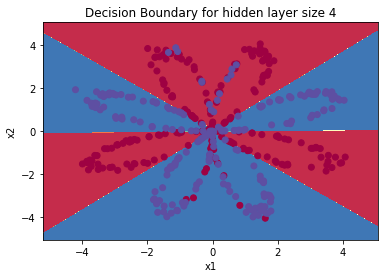

In [23]:
# Построим модель с n_h нейронов в скрытом слое
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Нарисуем границы
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
plt.title("Decision Boundary for hidden layer size " + str(4))

**Ожидаемый результат**: 

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218558 </td> 
  </tr>
  
</table>


In [30]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 89%


**Ожидаемый результат**: 

<table style="width:30%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td> 
  </tr>
</table>

Точность действительно высока по сравнению с логистической регрессией.
Модель выучила узоры листьев цветка.

### 4.6 - Настройка размера скрытого слоя

Выполните следующий код. Это может занять 1-2 минуты. Вы будете наблюдать различное поведение модели для различных размеров скрытого слоя.

Accuracy для 1 скрытых нейронов: 86.5 %
Accuracy для 2 скрытых нейронов: 87.0 %
Accuracy для 3 скрытых нейронов: 97.0 %
Accuracy для 4 скрытых нейронов: 98.5 %
Accuracy для 5 скрытых нейронов: 87.0 %
Accuracy для 20 скрытых нейронов: 98.5 %
Accuracy для 50 скрытых нейронов: 89.5 %


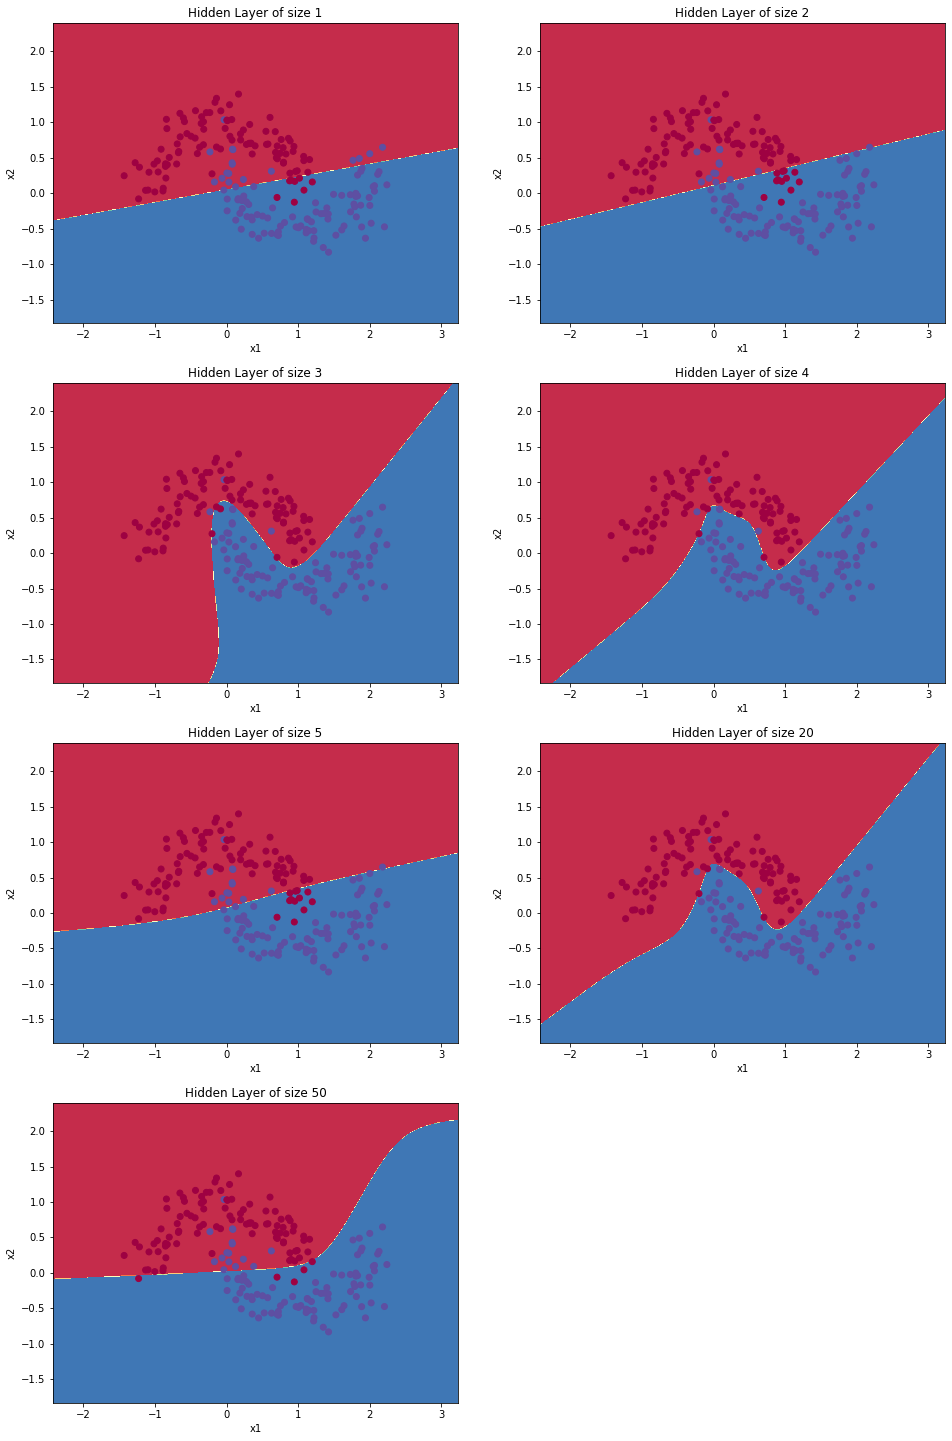

In [31]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy для {} скрытых нейронов: {} %".format(n_h, accuracy))

**Интерпретация**:
- Большие модели (с большим количеством скрытых нейронов) способны лучше соответствовать тренировочному набору, пока в конечном итоге самые большие модели не будут соответствовать данным.
- Лучший размер скрытого слоя, находится в районе n_h = 5. Действительно, значение здесь хорошо вписывается в данные, не вызывая также заметного переобучения.
- Позже вы также узнаете о регуляризации, которая позволяет использовать очень большие модели (например, n_h = 50) без большого переобучения.

## 5 Примеры на других наборах данных

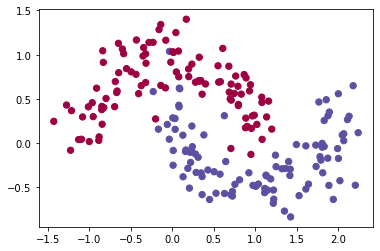

In [28]:
# Датасеты
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (выберите датасет)
dataset = "noisy_moons"
### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y % 2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

Accuracy для 50 скрытых нейронов: 89.5 %


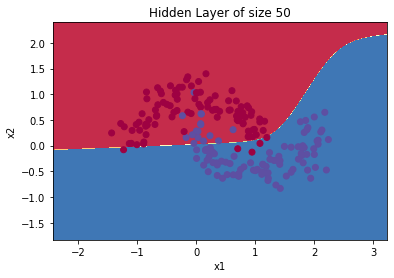

In [29]:
n_h = 50
plt.title('Hidden Layer of size %d' % n_h)
parameters = nn_model(X, Y, n_h, num_iterations = 5000)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
predictions = predict(parameters, X)
accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
print ("Accuracy для {} скрытых нейронов: {} %".format(n_h, accuracy))

Используемый материал:
- Курс Deep Learning; https://www.coursera.org/specializations/deep-learning
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/